<div id="top" >
    <h3>Outline</h3>
</div>

- [Necessary Packages](#necessary_packages)
- [Global Parameters](#global_parameters)
- [Download the dataset](#download_the_dataset)
- [Load the dataset](#load_the_dataset)
- [Getting familiar with the data](#getting_familiar_with_the_data)
- [Text Cleaning](#text_cleaning)
- [Data splitting](#data_splitting)
- [Training](#training)

<div id="necessary_packages" >
    <h3>Necessary Packages</h3>
</div>

[Back to top](#top)

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import requests
import re
import string
import warnings
import torch
import numpy as np
import random
import seaborn as sns
from torchviz import make_dot
from tqdm.notebook import tqdm
from textblob import Word
from unidecode import unidecode
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from typing import Callable,Optional
from torch.utils.data import DataLoader,Dataset
from trainer import Trainer
from torch.optim import Adam
from torchmetrics import Accuracy,F1Score,Precision,Recall,AUROC,Metric

In [27]:
tqdm.pandas()
warnings.filterwarnings("ignore")

<div id="global_parameters" >
    <h3>Global Parameters</h3>
</div>

[Back to top](#top)

In [28]:
### General
DOWNLOAD_DATASET = False
DATASET_URL = "https://raw.githubusercontent.com/GU4243-ADS/spring2018-project1-ginnyqg/master/data/spooky.csv"
DATA_DIR = os.path.join(".","data")
DATASET_PATH = os.path.join(DATA_DIR, "spooky.csv")
WEIGHTS_DIR = os.path.join(".","weights")
HISTORIES_DIR = os.path.join(".","histories")

### Preprocessing parameters
MIN_FREQ = 1

### Training params
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 0.001
EPOCHS = 100
HIDDEN_DIM = 64
BATCH_SIZE = 256

### Reproducibitlity

In [29]:
torch.cuda.manual_seed_all(0)
np.random.seed(0)
random.seed(0)

<div id="download_the_dataset" >
    <h3>Download the dataset</h3>
</div>

[Back to top](#top)

In [30]:
if DOWNLOAD_DATASET:
    response = requests.get(DATASET_URL)
    content = response.text
    if not os.path.isdir(DATA_DIR):
        os.mkdir(DATA_DIR)
    with open(DATASET_PATH, "w") as f:
        f.write(content)
else:
    print("Dataset download is deactivated")

Dataset download is deactivated


<div id="load_the_dataset" >
    <h3>Load the dataset</h3>
</div>

[Back to top](#top)

In [31]:
df = pd.read_csv(DATASET_PATH)

<div id="getting_familiar_with_the_data" >
    <h3>Getting familiar with the data</h3>
</div>

[Back to top](#top)

- show the columns of the dataframe

In [32]:
df.columns

Index(['id', 'text', 'author'], dtype='object')

- Check the dimensions of the dataframe

In [33]:
df.shape

(19579, 3)

- display the head and the tail of the dataframe

In [34]:
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [35]:
df.tail()

,id,text,author
19574,id17718,"I could have fancied, while I looked at it, th...",EAP
19575,id08973,The lids clenched themselves together as if in...,EAP
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,id17513,"For an item of news like this, it strikes us i...",EAP
19578,id00393,"He laid a gnarled claw on my shoulder, and it ...",HPL


- Check for missing values

In [36]:
df.isna().sum()

id        0
text      0
author    0
dtype: int64

- Checking for duplicates

In [37]:
df.duplicated().sum()

0

### Label encoding

In [38]:
encoder = LabelEncoder()
encoder.fit(df['author'])

LabelEncoder()

In [39]:
df['author'] = encoder.transform(df['author'])

### Data Splitting

In [40]:
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['author'])

<div id="text_cleaning" >
    <h3>Text Cleaning</h3>
</div>

[Back to top](#top)

In [41]:
class TextPreprocessor(Callable):

    def __init__(self) -> None:
        
        self.rx = re.compile(r'([^\W\d_])\1{2,}')
        self.url_regex = "((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*"
        self.email_regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
        self.spetial_chars = string.punctuation
        self.escaped_chars = [re.escape(c) for c in self.spetial_chars]
        self.spetial_chars_regex = re.compile(f"({'|'.join(self.escaped_chars)})")
        self.eng_stopwords = set(stopwords.words("english"))
        self.stemmer = SnowballStemmer(language="english")

    def remove_reptitive_characters(self, text):
        return re.sub(r'[^\W\d_]+', lambda x: Word(self.rx.sub(r'\1\1', x.group())).correct() if self.rx.search(x.group()) else x.group(), text)
    
    def normalaize_unicode_chars(self, text):
        text = unidecode(text)
        return text
    
    def remove_html_tags(self,text):
        return re.sub(" +"," ",BeautifulSoup(text, 'html.parser').get_text().replace("\n"," ")).strip()
    
    def handle_special_entries(self, text):
        text = re.sub(self.url_regex, "[URL]", text)
        text = re.sub(self.email_regex, "[EMAIL]", text)
        text = self.remove_html_tags(text)
        return text
    
    def remove_punctuation(self, text):
        return re.sub(self.spetial_chars_regex," ",text)
    
    def lower(self, text):
        return text.lower()
    
    def remove_stopwords(self, text):
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in self.eng_stopwords]
        return ' '.join(tokens)
    
    def stem(self, text):
        tokens = word_tokenize(text)
        tokens = [self.stemmer.stem(token) for token in tokens]
        return ' '.join(tokens)

    def __call__(self, text : str) -> str:
        text = self.remove_reptitive_characters(text)
        text = self.normalaize_unicode_chars(text)
        text = self.handle_special_entries(text)
        text = self.lower(text)
        text = self.remove_punctuation(text)
        text = self.remove_stopwords(text)
        text = self.stem(text)
        return text

### Indexing and padding

In [42]:
class Tokenizer(Callable):

    def __init__(self, 
        docs : list[str],
        preprocessor : Optional[Callable] = None,
        min_freq : int = 5,
        pad_token : str = '<pad>',
        sos_token : str = '<sos>',
        eos_token : str = '<eos>',
        unk_token : str = '<unk>',
    ):
        
        self.min_freq = min_freq
        self.preprocessor = preprocessor
        self.pad_token = pad_token 
        self.sos_token = sos_token 
        self.eos_token = eos_token 
        self.unk_token = unk_token 

        self.freqs = {
            pad_token : 0,
            sos_token : 0,
            eos_token : 0,
            unk_token : 0
        }

        self.stoi = {
            pad_token : 0,
            sos_token : 1,
            eos_token : 2,
            unk_token : 3
        }

        self.itos = {
            0 : pad_token,
            1 : sos_token,
            2 : eos_token,
            3 : unk_token
        }

        i = 4

        for doc in tqdm(docs):

            doc = self._preprocess(doc)
            tokenized_document = word_tokenize(doc)

            for token in tokenized_document:

                if token not in self.freqs.keys():
                    self.freqs[token] = 1
                else:
                    self.freqs[token] += 1

                if self.freqs[token] >= self.min_freq and token not in self.stoi.keys():

                    self.stoi[token] = i
                    self.itos[i] = token
                    i += 1

    def _preprocess(self, doc : str):

        if self.preprocessor is None:
            return doc
        else:
            return self.preprocessor(doc)

    def __call__(self, doc : str) -> list[int]:

        doc = self._preprocess(doc)
        tokenized_document = word_tokenize(doc)
        
        sequence = [self.stoi.get(token, self.stoi[self.unk_token]) for token in tokenized_document]
        sequence = [self.stoi[self.sos_token]] + sequence + [self.stoi[self.eos_token]]
        sequence = torch.tensor(sequence)

        return sequence

In [43]:
class Collate:

    def __init__(self):
        pass

    def __call__(self, batch : list[tuple[torch.Tensor,torch.Tensor]]) -> tuple[torch.Tensor,torch.Tensor]:

        docs = [row[0] for row in batch]
        labels = torch.tensor([row[1] for row in batch])

        maxlen = max([len(doc) for doc in docs])

        docs = torch.nn.utils.rnn.pad_sequence(sequences=docs, batch_first=True)
        docs_ = torch.zeros(size=(docs.size(0),maxlen)).type(torch.long)
        docs_[:,:docs.size(1)] = docs

        return docs_,labels

### Data Loading

In [44]:
class SpookyDataset(Dataset):

    def __init__(self, preprocessor : Optional[Callable],df : pd.DataFrame):
        self.preprocessor = preprocessor
        self.df = df

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index : int):

        x = self.df['text'].iloc[index]
        y = self.df['author'].iloc[index]

        if self.preprocessor is not None:
            x = self.preprocessor(x)

        return x,y

### Create data loaders

In [45]:
preprocessor = TextPreprocessor()
tokenizer = Tokenizer(train_df['text'].tolist(), preprocessor=preprocessor,min_freq=MIN_FREQ)

  0%|          | 0/13705 [00:00<?, ?it/s]

In [46]:
print(len(tokenizer.itos))

13320


In [47]:
train_data = SpookyDataset(preprocessor=tokenizer,df=train_df)
test_data = SpookyDataset(preprocessor=tokenizer,df=test_df)

In [48]:
print(len(train_data))
print(len(test_data))

13705
5874


In [49]:
train_loader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True,collate_fn=Collate(),num_workers=4,prefetch_factor=2)
test_loader = DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=True,collate_fn=Collate(),num_workers=4,prefetch_factor=2)

### Model

In [50]:
class Model(torch.nn.Module):

    def __init__(self,
        vocab_size : int,
        hidden_dim : int
    ) -> None:
        
        super().__init__()

        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim

        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size,embedding_dim=hidden_dim,padding_idx=tokenizer.stoi[tokenizer.pad_token])

        self.dropout = torch.nn.Dropout(p=0.35)

        self.fc2 = torch.nn.Linear(in_features=hidden_dim,out_features=3)

    def forward(self, x : torch.Tensor) -> torch.Tensor:

        y = self.embedding(x)

        y = torch.mean(y, dim=1)

        y = self.dropout(y)

        y = self.fc2(y)

        return y

### Training

In [51]:
model = Model(vocab_size=len(tokenizer.itos), hidden_dim=HIDDEN_DIM).to(DEVICE)

In [55]:
x, y = next(iter(train_loader))
y_hat = model(x.to(DEVICE))

In [57]:
make_dot(y_hat, params=dict(model.named_parameters())).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

In [26]:
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
accuracy = Accuracy(task='multiclass',num_classes=3).to(device=DEVICE)
loss = torch.nn.CrossEntropyLoss()

In [27]:
trainer = Trainer() \
        .set_optimizer(optimizer=optimizer) \
        .set_loss(loss=loss) \
        .set_device(device=DEVICE) \
        .set_save_every(save_every=5) \
        .set_weights_folder(WEIGHTS_DIR) \
        .add_metric("accuracy", accuracy) \
        .set_save_best_weights(True) \
        .set_score_metric("accuracy")

In [28]:
trainer.train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=test_loader,
    epochs=EPOCHS
)

accuracy = 0.39416059851646423,loss = 1.084952473640442: 100%|██████████| 54/54 [00:02<00:00, 20.78it/s]


Epoch 1 : accuracy = 0.39488607589845304,loss = 1.0908476357106809,val_accuracy = 0.40531238783960755,val_loss = 1.0853196538012961



accuracy = 0.38686132431030273,loss = 1.077278971672058: 100%|██████████| 54/54 [00:02<00:00, 26.06it/s]


Epoch 2 : accuracy = 0.40639731619093156,loss = 1.0809141176718253,val_accuracy = 0.40468497379966406,val_loss = 1.0764826069707456



accuracy = 0.32846716046333313,loss = 1.086335301399231: 100%|██████████| 54/54 [00:02<00:00, 23.98it/s]


Epoch 3 : accuracy = 0.40893284093450616,loss = 1.0712447696261935,val_accuracy = 0.4082908500795779,val_loss = 1.0659779984018076



accuracy = 0.37956205010414124,loss = 1.0804340839385986: 100%|██████████| 54/54 [00:02<00:00, 26.45it/s]


Epoch 4 : accuracy = 0.423840269446373,loss = 1.0573805371920268,val_accuracy = 0.423167726267939,val_loss = 1.0502731385438338



accuracy = 0.5328466892242432,loss = 0.9918647408485413: 100%|██████████| 54/54 [00:02<00:00, 25.03it/s]


Epoch 5 : accuracy = 0.4532992442448934,loss = 1.0376353363196056,val_accuracy = 0.45418612982915796,val_loss = 1.0294850157654805



accuracy = 0.46715328097343445,loss = 0.9860892295837402: 100%|██████████| 54/54 [00:02<00:00, 25.64it/s]


Epoch 6 : accuracy = 0.5000427690921007,loss = 1.0100920928849115,val_accuracy = 0.5103895301404207,val_loss = 1.0010667287785073



accuracy = 0.7080292105674744,loss = 0.8699243068695068: 100%|██████████| 54/54 [00:02<00:00, 26.41it/s]


Epoch 7 : accuracy = 0.5663523927882865,loss = 0.9703315937960589,val_accuracy = 0.5696794701659161,val_loss = 0.9623113974280979



accuracy = 0.6861313581466675,loss = 0.8701242804527283: 100%|██████████| 54/54 [00:02<00:00, 24.50it/s]


Epoch 8 : accuracy = 0.6224428260767901,loss = 0.930045900521455,val_accuracy = 0.6181419543598009,val_loss = 0.9208283217056937



accuracy = 0.6715328693389893,loss = 0.8805627226829529: 100%|██████████| 54/54 [00:02<00:00, 25.52it/s]


Epoch 9 : accuracy = 0.6594988725803517,loss = 0.8855155485647696,val_accuracy = 0.6578669599864794,val_loss = 0.8800472021102905



accuracy = 0.6934306621551514,loss = 0.859902560710907: 100%|██████████| 54/54 [00:02<00:00, 26.65it/s]


Epoch 10 : accuracy = 0.7008476742991695,loss = 0.8431851654141037,val_accuracy = 0.6882818108019622,val_loss = 0.8439954674762228



accuracy = 0.7956204414367676,loss = 0.7213379740715027: 100%|██████████| 54/54 [00:02<00:00, 26.47it/s]


Epoch 11 : accuracy = 0.7180757257673476,loss = 0.7982158097955916,val_accuracy = 0.7045047490493112,val_loss = 0.8066717360330664



accuracy = 0.7445255517959595,loss = 0.7180353999137878: 100%|██████████| 54/54 [00:02<00:00, 25.66it/s]


Epoch 12 : accuracy = 0.7434605426258512,loss = 0.7628237914156031,val_accuracy = 0.7291900593301525,val_loss = 0.7544846560644067



accuracy = 0.7883211970329285,loss = 0.5710198283195496: 100%|██████████| 54/54 [00:01<00:00, 27.54it/s]


Epoch 13 : accuracy = 0.7585944897598691,loss = 0.7162920225549627,val_accuracy = 0.737721209940703,val_loss = 0.7334888940272124



accuracy = 0.8321167826652527,loss = 0.6157858371734619: 100%|██████████| 54/54 [00:02<00:00, 24.71it/s]


Epoch 14 : accuracy = 0.7795154728271343,loss = 0.680282367600335,val_accuracy = 0.7471633009288622,val_loss = 0.7142861511396326



accuracy = 0.8394160866737366,loss = 0.6570400595664978: 100%|██████████| 54/54 [00:02<00:00, 25.83it/s]


Epoch 15 : accuracy = 0.7884035386421062,loss = 0.6479054347232536,val_accuracy = 0.7572819357332976,val_loss = 0.6804705910060717



accuracy = 0.7883211970329285,loss = 0.5822402238845825: 100%|██████████| 54/54 [00:02<00:00, 24.68it/s]


Epoch 16 : accuracy = 0.8007675221672764,loss = 0.620698027588703,val_accuracy = 0.7609397457993549,val_loss = 0.6588172031485516



accuracy = 0.8321167826652527,loss = 0.507070004940033: 100%|██████████| 54/54 [00:02<00:00, 24.97it/s]


Epoch 17 : accuracy = 0.8042550561604677,loss = 0.5976862283768477,val_accuracy = 0.7682918621146161,val_loss = 0.6424110454061757



accuracy = 0.8321167826652527,loss = 0.5118419528007507: 100%|██████████| 54/54 [00:02<00:00, 25.98it/s]


Epoch 18 : accuracy = 0.8155397783826899,loss = 0.5804381144267542,val_accuracy = 0.7710611872051073,val_loss = 0.6199184215587118



accuracy = 0.8321167826652527,loss = 0.45157307386398315: 100%|██████████| 54/54 [00:02<00:00, 23.88it/s]


Epoch 19 : accuracy = 0.8263904728271343,loss = 0.554967897909659,val_accuracy = 0.7781129298002823,val_loss = 0.6101566268050153



accuracy = 0.8905109763145447,loss = 0.3671039640903473: 100%|██████████| 54/54 [00:02<00:00, 26.41it/s]


Epoch 20 : accuracy = 0.8297143236354545,loss = 0.5314074760233914,val_accuracy = 0.780680132948834,val_loss = 0.5948298521663832



accuracy = 0.8613138794898987,loss = 0.40935218334198: 100%|██████████| 54/54 [00:02<00:00, 26.26it/s]


Epoch 21 : accuracy = 0.8344543079535166,loss = 0.5085237627779996,val_accuracy = 0.7880420736644579,val_loss = 0.5774191890073859



accuracy = 0.8321167826652527,loss = 0.40407994389533997: 100%|██████████| 54/54 [00:02<00:00, 25.28it/s]


Epoch 22 : accuracy = 0.8411474172715787,loss = 0.49603821447602026,val_accuracy = 0.7847632377044015,val_loss = 0.5800147600795912



accuracy = 0.8394160866737366,loss = 0.4278866648674011: 100%|██████████| 54/54 [00:02<00:00, 24.96it/s]


Epoch 23 : accuracy = 0.8464909229013655,loss = 0.4830963451553274,val_accuracy = 0.7884828085484712,val_loss = 0.555274231278378



accuracy = 0.8394160866737366,loss = 0.3742453455924988: 100%|██████████| 54/54 [00:02<00:00, 25.51it/s]


Epoch 24 : accuracy = 0.8475759923458099,loss = 0.4691551035201108,val_accuracy = 0.7906485795974731,val_loss = 0.5557453852632771



accuracy = 0.8759124279022217,loss = 0.49532729387283325: 100%|██████████| 54/54 [00:02<00:00, 24.66it/s]


Epoch 25 : accuracy = 0.8555579847759671,loss = 0.45267782553478525,val_accuracy = 0.7918402474859486,val_loss = 0.5415026415949282



accuracy = 0.7956204414367676,loss = 0.4792080521583557: 100%|██████████| 54/54 [00:02<00:00, 24.80it/s]


Epoch 26 : accuracy = 0.8564582489154957,loss = 0.43104348745610976,val_accuracy = 0.7970925595449365,val_loss = 0.5364115186359572



accuracy = 0.8832116723060608,loss = 0.33038023114204407: 100%|██████████| 54/54 [00:02<00:00, 25.02it/s]


Epoch 27 : accuracy = 0.8623482485612234,loss = 0.4272889373479066,val_accuracy = 0.797722780186197,val_loss = 0.5268173243688501



accuracy = 0.8832116723060608,loss = 0.3907771408557892: 100%|██████████| 54/54 [00:01<00:00, 28.52it/s]


Epoch 28 : accuracy = 0.8643737115241863,loss = 0.4169106384118398,val_accuracy = 0.7991600788157919,val_loss = 0.5236034432183141



accuracy = 0.8759124279022217,loss = 0.3436938524246216: 100%|██████████| 54/54 [00:02<00:00, 24.40it/s]


Epoch 29 : accuracy = 0.8666256931093004,loss = 0.4050135021960294,val_accuracy = 0.8011981222940527,val_loss = 0.5222789567449818



accuracy = 0.8686131238937378,loss = 0.32963964343070984: 100%|██████████| 54/54 [00:02<00:00, 23.08it/s]


Epoch 30 : accuracy = 0.8725669097017359,loss = 0.4016078456684395,val_accuracy = 0.8039548137913579,val_loss = 0.5163057420564734



accuracy = 0.8832116723060608,loss = 0.3063540458679199: 100%|██████████| 54/54 [00:02<00:00, 24.77it/s]


Epoch 31 : accuracy = 0.87471804022789,loss = 0.39190942600921347,val_accuracy = 0.8043071212975875,val_loss = 0.5067881967710413



accuracy = 0.9270073175430298,loss = 0.20368435978889465: 100%|██████████| 54/54 [00:02<00:00, 25.11it/s]


Epoch 32 : accuracy = 0.8769758299545005,loss = 0.3843374486874651,val_accuracy = 0.8049247109371683,val_loss = 0.5042088588942653



accuracy = 0.9051094651222229,loss = 0.41328874230384827: 100%|██████████| 54/54 [00:02<00:00, 26.57it/s]


Epoch 33 : accuracy = 0.8788851289837448,loss = 0.3691452117981734,val_accuracy = 0.8065739533175593,val_loss = 0.5016034958155259



accuracy = 0.8832116723060608,loss = 0.31642594933509827: 100%|██████████| 54/54 [00:02<00:00, 23.05it/s]


Epoch 34 : accuracy = 0.8841219754130752,loss = 0.36417442670574895,val_accuracy = 0.8073220771291981,val_loss = 0.49516652070957684



accuracy = 0.8467153310775757,loss = 0.3189777433872223: 100%|██████████| 54/54 [00:02<00:00, 24.40it/s]


Epoch 35 : accuracy = 0.8873523672421774,loss = 0.3507979208672488,val_accuracy = 0.8064434165539949,val_loss = 0.49686991909275885



accuracy = 0.9124087691307068,loss = 0.2822886109352112: 100%|██████████| 54/54 [00:02<00:00, 26.22it/s]


Epoch 36 : accuracy = 0.8903050235024205,loss = 0.34970271918508744,val_accuracy = 0.8077529876128487,val_loss = 0.49073571355446527



accuracy = 0.8905109763145447,loss = 0.29617780447006226: 100%|██████████| 54/54 [00:02<00:00, 25.72it/s]


Epoch 37 : accuracy = 0.8928653653021212,loss = 0.341132361303877,val_accuracy = 0.8078807151835897,val_loss = 0.48794460944507434



accuracy = 0.8321167826652527,loss = 0.4263717234134674: 100%|██████████| 54/54 [00:02<00:00, 25.70it/s]


Epoch 38 : accuracy = 0.8931584126419492,loss = 0.33537344441369726,val_accuracy = 0.8115385252496471,val_loss = 0.48668293330980383



accuracy = 0.9051094651222229,loss = 0.23588642477989197: 100%|██████████| 54/54 [00:02<00:00, 26.63it/s]


Epoch 39 : accuracy = 0.8964632539837448,loss = 0.3285858719437211,val_accuracy = 0.8125477225884147,val_loss = 0.48625760622646497



accuracy = 0.8905109763145447,loss = 0.3457566201686859: 100%|██████████| 54/54 [00:02<00:00, 25.01it/s]


Epoch 40 : accuracy = 0.8974226569687879,loss = 0.31980979166649004,val_accuracy = 0.8102093053900677,val_loss = 0.48294979074726935



accuracy = 0.9416058659553528,loss = 0.32942357659339905: 100%|██████████| 54/54 [00:02<00:00, 24.23it/s]


Epoch 41 : accuracy = 0.9035048539991732,loss = 0.3082992144756847,val_accuracy = 0.8119371507478796,val_loss = 0.48079940028812573



accuracy = 0.8832116723060608,loss = 0.2828642725944519: 100%|██████████| 54/54 [00:02<00:00, 26.96it/s]


Epoch 42 : accuracy = 0.9045936189315937,loss = 0.30617346035109627,val_accuracy = 0.8137365812840669,val_loss = 0.4788036165030106



accuracy = 0.8832116723060608,loss = 0.29903700947761536: 100%|██████████| 54/54 [00:02<00:00, 25.77it/s]


Epoch 43 : accuracy = 0.9056786883760382,loss = 0.301439484236417,val_accuracy = 0.8124887710032256,val_loss = 0.47626996299494867



accuracy = 0.9270073175430298,loss = 0.1716749221086502: 100%|██████████| 54/54 [00:02<00:00, 25.59it/s]


Epoch 44 : accuracy = 0.9077194642137598,loss = 0.2944194423379721,val_accuracy = 0.810894269010295,val_loss = 0.47646146235258685



accuracy = 0.8540145754814148,loss = 0.3458556532859802: 100%|██████████| 54/54 [00:02<00:00, 23.63it/s]


Epoch 45 : accuracy = 0.9099123069533596,loss = 0.288690997770539,val_accuracy = 0.8137267568837041,val_loss = 0.47942188252573426



accuracy = 0.8978102207183838,loss = 0.2595173716545105: 100%|██████████| 54/54 [00:01<00:00, 27.03it/s]


Epoch 46 : accuracy = 0.9101446337170072,loss = 0.2867284193634987,val_accuracy = 0.8139064182405886,val_loss = 0.47908210365668585



accuracy = 0.8759124279022217,loss = 0.48684871196746826: 100%|██████████| 54/54 [00:02<00:00, 24.50it/s]


Epoch 47 : accuracy = 0.9149474523685597,loss = 0.2794001817151352,val_accuracy = 0.8140959065893422,val_loss = 0.47710546332856885



accuracy = 0.8978102207183838,loss = 0.5365931987762451: 100%|██████████| 54/54 [00:02<00:00, 24.46it/s]


Epoch 48 : accuracy = 0.9169444022355256,loss = 0.27726002037525177,val_accuracy = 0.8142755679462267,val_loss = 0.47672593334446783



accuracy = 0.8978102207183838,loss = 0.2973717451095581: 100%|██████████| 54/54 [00:02<00:00, 24.25it/s]


Epoch 49 : accuracy = 0.9177401198281182,loss = 0.26767203818868707,val_accuracy = 0.8177312586618506,val_loss = 0.4737449171750442



accuracy = 0.9489051103591919,loss = 0.20411884784698486: 100%|██████████| 54/54 [00:02<00:00, 26.20it/s]


Epoch 50 : accuracy = 0.9201330807473924,loss = 0.2655188264670195,val_accuracy = 0.8143541709236477,val_loss = 0.46997573842173035



accuracy = 0.956204354763031,loss = 0.172124445438385: 100%|██████████| 54/54 [00:02<00:00, 23.34it/s]


Epoch 51 : accuracy = 0.9190385065696858,loss = 0.26249509691088285,val_accuracy = 0.8160230646962705,val_loss = 0.4749048106048418



accuracy = 0.8905109763145447,loss = 0.26188161969184875: 100%|██████████| 54/54 [00:02<00:00, 25.90it/s]


Epoch 52 : accuracy = 0.9180389764132323,loss = 0.2588935591004513,val_accuracy = 0.8164637969887775,val_loss = 0.4718778988589411



accuracy = 0.8978102207183838,loss = 0.24591562151908875: 100%|██████████| 54/54 [00:02<00:00, 26.86it/s]


Epoch 53 : accuracy = 0.9202719485318219,loss = 0.25367291630418215,val_accuracy = 0.816284135631893,val_loss = 0.47821203910786175



accuracy = 0.8759124279022217,loss = 0.29994264245033264: 100%|██████████| 54/54 [00:02<00:00, 24.23it/s]


Epoch 54 : accuracy = 0.9237003458870782,loss = 0.2471242938880567,val_accuracy = 0.8176428312840669,val_loss = 0.47365414448406384



accuracy = 0.9635036587715149,loss = 0.1458822339773178: 100%|██████████| 54/54 [00:01<00:00, 27.40it/s]


Epoch 55 : accuracy = 0.9259011094216947,loss = 0.24631521022982067,val_accuracy = 0.8163950210032256,val_loss = 0.47438619836517004



accuracy = 0.9197080135345459,loss = 0.23369331657886505: 100%|██████████| 54/54 [00:02<00:00, 24.05it/s]


Epoch 56 : accuracy = 0.9264645002506398,loss = 0.23883410074092723,val_accuracy = 0.8174435185349506,val_loss = 0.47665984086368396



accuracy = 0.9197080135345459,loss = 0.18079480528831482: 100%|██████████| 54/54 [00:02<00:00, 24.10it/s]


Epoch 57 : accuracy = 0.9284176252506398,loss = 0.23537351963696657,val_accuracy = 0.817541770313097,val_loss = 0.4739994043889253



accuracy = 0.9197080135345459,loss = 0.18987178802490234: 100%|██████████| 54/54 [00:02<00:00, 25.07it/s]


Epoch 58 : accuracy = 0.9247283891395286,loss = 0.2364141927273185,val_accuracy = 0.8165157307749209,val_loss = 0.4660534353359886



accuracy = 0.956204354763031,loss = 0.1678859293460846: 100%|██████████| 54/54 [00:02<00:00, 24.78it/s]


Epoch 59 : accuracy = 0.9280807519400561,loss = 0.23244563269394417,val_accuracy = 0.819220491077589,val_loss = 0.4708031027213387



accuracy = 0.9197080135345459,loss = 0.17104843258857727: 100%|██████████| 54/54 [00:02<00:00, 24.62it/s]


Epoch 60 : accuracy = 0.931817509509899,loss = 0.23051124369656598,val_accuracy = 0.8188808171645455,val_loss = 0.471025833617086



accuracy = 0.9416058659553528,loss = 0.17717355489730835: 100%|██████████| 54/54 [00:02<00:00, 22.84it/s]


Epoch 61 : accuracy = 0.9327293910362102,loss = 0.22181453473038143,val_accuracy = 0.8188808171645455,val_loss = 0.479883822410003



accuracy = 0.9416058659553528,loss = 0.20560511946678162: 100%|██████████| 54/54 [00:02<00:00, 24.83it/s]


Epoch 62 : accuracy = 0.9342484882584324,loss = 0.21752655492336662,val_accuracy = 0.8197201749552852,val_loss = 0.4734838319861371



accuracy = 0.9416058659553528,loss = 0.2635190188884735: 100%|██████████| 54/54 [00:02<00:00, 26.25it/s]


Epoch 63 : accuracy = 0.9335974465917658,loss = 0.21774301940092333,val_accuracy = 0.8210100946219071,val_loss = 0.47700840753057727



accuracy = 0.9197080135345459,loss = 0.17501147091388702: 100%|██████████| 54/54 [00:02<00:00, 24.52it/s]


Epoch 64 : accuracy = 0.9353620696950842,loss = 0.21592061469952264,val_accuracy = 0.8188218655793563,val_loss = 0.477718323469162



accuracy = 0.9197080135345459,loss = 0.1702859252691269: 100%|██████████| 54/54 [00:02<00:00, 24.08it/s]


Epoch 65 : accuracy = 0.9347833659913805,loss = 0.21356314751836988,val_accuracy = 0.8210297460141389,val_loss = 0.4823781290779943



accuracy = 0.956204354763031,loss = 0.11756855249404907: 100%|██████████| 54/54 [00:02<00:00, 26.13it/s]


Epoch 66 : accuracy = 0.938135728791908,loss = 0.21108946949243546,val_accuracy = 0.8211083464000536,val_loss = 0.48043518221896625



accuracy = 0.9489051103591919,loss = 0.22950097918510437: 100%|██████████| 54/54 [00:02<00:00, 22.68it/s]


Epoch 67 : accuracy = 0.9380005575992443,loss = 0.21030909016176505,val_accuracy = 0.8199096633040387,val_loss = 0.4808262120122495



accuracy = 0.9197080135345459,loss = 0.18643945455551147: 100%|██████████| 54/54 [00:02<00:00, 22.19it/s]


Epoch 68 : accuracy = 0.9363024632136027,loss = 0.20539333436776092,val_accuracy = 0.8197693021401115,val_loss = 0.48689923597418744



accuracy = 0.9489051103591919,loss = 0.15529733896255493: 100%|██████████| 54/54 [00:02<00:00, 25.01it/s]


Epoch 69 : accuracy = 0.9410387520436887,loss = 0.19741605760322678,val_accuracy = 0.8205398839452992,val_loss = 0.4851424318292867



accuracy = 0.9197080135345459,loss = 0.2542475461959839: 100%|██████████| 54/54 [00:02<00:00, 23.46it/s]


Epoch 70 : accuracy = 0.9428852178432323,loss = 0.19944847388951867,val_accuracy = 0.8182800697243732,val_loss = 0.47967010477314825



accuracy = 0.970802903175354,loss = 0.13571156561374664: 100%|██████████| 54/54 [00:02<00:00, 25.31it/s]


Epoch 71 : accuracy = 0.9427463500588028,loss = 0.1949762475711328,val_accuracy = 0.8202100370241248,val_loss = 0.4803795425788216



accuracy = 0.985401451587677,loss = 0.09467095136642456: 100%|██████████| 54/54 [00:02<00:00, 24.79it/s]


Epoch 72 : accuracy = 0.94301669354792,loss = 0.19423510354978066,val_accuracy = 0.8199293146962705,val_loss = 0.49222021387970966



accuracy = 0.9416058659553528,loss = 0.1455698013305664: 100%|██████████| 54/54 [00:02<00:00, 25.03it/s]


Epoch 73 : accuracy = 0.9456055484436177,loss = 0.1865351333938263,val_accuracy = 0.8207195478936901,val_loss = 0.5022990742455358



accuracy = 0.9635036587715149,loss = 0.09549490362405777: 100%|██████████| 54/54 [00:02<00:00, 25.57it/s]


Epoch 74 : accuracy = 0.9437685862735465,loss = 0.18350263229674763,val_accuracy = 0.8188906415649082,val_loss = 0.4969716862491939



accuracy = 0.956204354763031,loss = 0.18858489394187927: 100%|██████████| 54/54 [00:02<00:00, 25.53it/s]


Epoch 75 : accuracy = 0.9455865389770932,loss = 0.18562350256575477,val_accuracy = 0.820628311323083,val_loss = 0.5023140272368556



accuracy = 0.9489051103591919,loss = 0.12314187735319138: 100%|██████████| 54/54 [00:02<00:00, 24.34it/s]


Epoch 76 : accuracy = 0.9471151409325776,loss = 0.1804520663011957,val_accuracy = 0.8171234960141389,val_loss = 0.5011552883231122



accuracy = 0.9343065619468689,loss = 0.15987125039100647: 100%|██████████| 54/54 [00:02<00:00, 21.79it/s]


Epoch 77 : accuracy = 0.948002204850868,loss = 0.17669885329626225,val_accuracy = 0.8166631097378938,val_loss = 0.4979986146740291



accuracy = 0.956204354763031,loss = 0.1394510269165039: 100%|██████████| 54/54 [00:02<00:00, 25.00it/s]


Epoch 78 : accuracy = 0.9502885065696858,loss = 0.17594660639210982,val_accuracy = 0.8176723070766615,val_loss = 0.49971721094587573



accuracy = 0.9635036587715149,loss = 0.1338679939508438: 100%|██████████| 54/54 [00:02<00:00, 26.77it/s]


Epoch 79 : accuracy = 0.9512917344216947,loss = 0.1758555935488807,val_accuracy = 0.8158139249552852,val_loss = 0.5083755008552385



accuracy = 0.956204354763031,loss = 0.18469782173633575: 100%|██████████| 54/54 [00:02<00:00, 25.64it/s]


Epoch 80 : accuracy = 0.9502885065696858,loss = 0.1713406769213853,val_accuracy = 0.817541770313097,val_loss = 0.499479898939962



accuracy = 0.9635036587715149,loss = 0.10851844400167465: 100%|██████████| 54/54 [00:02<00:00, 24.74it/s]


Epoch 81 : accuracy = 0.9513640723846577,loss = 0.17327095278435284,val_accuracy = 0.8195208622061688,val_loss = 0.5154586952665577



accuracy = 0.956204354763031,loss = 0.11413835734128952: 100%|██████████| 54/54 [00:01<00:00, 27.02it/s]


Epoch 82 : accuracy = 0.9526756593474636,loss = 0.1684519331212397,val_accuracy = 0.8188906415649082,val_loss = 0.5132189561491427



accuracy = 0.970802903175354,loss = 0.0856318399310112: 100%|██████████| 54/54 [00:02<00:00, 25.78it/s]


Epoch 83 : accuracy = 0.9527289889476918,loss = 0.16696388922907687,val_accuracy = 0.8197201749552852,val_loss = 0.5113817297894022



accuracy = 0.9489051103591919,loss = 0.12614548206329346: 100%|██████████| 54/54 [00:02<00:00, 25.47it/s]


Epoch 84 : accuracy = 0.9564467381547999,loss = 0.16397168915028926,val_accuracy = 0.8200500244679658,val_loss = 0.5192990238251893



accuracy = 0.9416058659553528,loss = 0.13918039202690125: 100%|██████████| 54/54 [00:02<00:00, 26.15it/s]


Epoch 85 : accuracy = 0.9532733725176917,loss = 0.16487325700344863,val_accuracy = 0.8174729943275452,val_loss = 0.5219280914120052



accuracy = 0.985401451587677,loss = 0.254607617855072: 100%|██████████| 54/54 [00:02<00:00, 24.13it/s]


Epoch 86 : accuracy = 0.9543737537331052,loss = 0.16208259678549236,val_accuracy = 0.8194001524344735,val_loss = 0.515816189672636



accuracy = 0.9635036587715149,loss = 0.10542859882116318: 100%|██████████| 54/54 [00:02<00:00, 24.51it/s]


Epoch 87 : accuracy = 0.9554873362735465,loss = 0.16015151515603065,val_accuracy = 0.8190113513366036,val_loss = 0.5179584635340649



accuracy = 0.970802903175354,loss = 0.04391397535800934: 100%|██████████| 54/54 [00:02<00:00, 23.04it/s]


Epoch 88 : accuracy = 0.9562735491328769,loss = 0.15392531371778911,val_accuracy = 0.8184821916663129,val_loss = 0.5334576718185259



accuracy = 0.985401451587677,loss = 0.08006913959980011: 100%|██████████| 54/54 [00:02<00:00, 24.81it/s]


Epoch 89 : accuracy = 0.9572672722516237,loss = 0.1560463542463603,val_accuracy = 0.8182112937388213,val_loss = 0.5213431236536606



accuracy = 0.9489051103591919,loss = 0.35923728346824646: 100%|██████████| 54/54 [00:01<00:00, 27.17it/s]


Epoch 90 : accuracy = 0.9555786825992443,loss = 0.152556876755423,val_accuracy = 0.8193805010422416,val_loss = 0.5459717551003331



accuracy = 0.9489051103591919,loss = 0.10945282131433487: 100%|██████████| 54/54 [00:02<00:00, 25.70it/s]


Epoch 91 : accuracy = 0.9565914140807258,loss = 0.1545166806490333,val_accuracy = 0.8170743688293125,val_loss = 0.533128366522167



accuracy = 0.9124087691307068,loss = 0.19016483426094055: 100%|██████████| 54/54 [00:02<00:00, 25.23it/s]


Epoch 92 : accuracy = 0.9560602318357538,loss = 0.15146424345396184,val_accuracy = 0.8191292545069819,val_loss = 0.5432202725306802



accuracy = 0.956204354763031,loss = 0.15015240013599396: 100%|██████████| 54/54 [00:02<00:00, 24.95it/s]


Epoch 93 : accuracy = 0.9584626963845005,loss = 0.14752663671970367,val_accuracy = 0.8171361270158187,val_loss = 0.5524714304053265



accuracy = 0.970802903175354,loss = 0.10347729921340942: 100%|██████████| 54/54 [00:02<00:00, 23.69it/s]


Epoch 94 : accuracy = 0.958081998206951,loss = 0.14512274690248347,val_accuracy = 0.8178126682405886,val_loss = 0.55006361655567



accuracy = 0.9635036587715149,loss = 0.08625319600105286: 100%|██████████| 54/54 [00:02<00:00, 24.76it/s]


Epoch 95 : accuracy = 0.9604786557179911,loss = 0.14470000889290263,val_accuracy = 0.8158434007478796,val_loss = 0.5492907918017843



accuracy = 0.9927007555961609,loss = 0.04292898252606392: 100%|██████████| 54/54 [00:02<00:00, 25.53it/s]


Epoch 96 : accuracy = 0.9596449213999289,loss = 0.1413826763767887,val_accuracy = 0.8162546598392985,val_loss = 0.556860731995624



accuracy = 0.956204354763031,loss = 0.16712720692157745: 100%|██████████| 54/54 [00:02<00:00, 25.17it/s]


Epoch 97 : accuracy = 0.9604881593474636,loss = 0.13965129797105436,val_accuracy = 0.8163430872170822,val_loss = 0.553068519934364



accuracy = 0.985401451587677,loss = 0.06805787980556488: 100%|██████████| 54/54 [00:02<00:00, 26.72it/s]


Epoch 98 : accuracy = 0.9603778046590311,loss = 0.13522393822118087,val_accuracy = 0.8148931575858075,val_loss = 0.5786981375321097



accuracy = 0.9635036587715149,loss = 0.09949842095375061: 100%|██████████| 54/54 [00:01<00:00, 28.98it/s]


Epoch 99 : accuracy = 0.9612020353476206,loss = 0.13821253297781502,val_accuracy = 0.8142362677532694,val_loss = 0.5522661416426949



accuracy = 0.9635036587715149,loss = 0.09873192757368088: 100%|██████████| 54/54 [00:02<00:00, 24.85it/s]


Epoch 100 : accuracy = 0.9637338640513243,loss = 0.1342031892940954,val_accuracy = 0.8131386430367179,val_loss = 0.5671383868093076



### Save the best model and the history

In [29]:
torch.save(trainer.best_weights, f=os.path.join(WEIGHTS_DIR, "best_weights.pt"))

In [30]:
def history2df(history : dict) -> pd.DataFrame:
    
    dfs = []

    for key in history.keys():
        df = pd.DataFrame(history[key])
        df["split"] = [key for _ in range(len(df))]
        dfs.append(df)

    return pd.concat(dfs)    

In [31]:
history_df = history2df(trainer.history)

In [32]:
history_df.to_csv(os.path.join(HISTORIES_DIR, "history.csv"))

### Evaluation

In [33]:
weights = torch.load(f=os.path.join(WEIGHTS_DIR, "best_weights.pt"))

In [34]:
model = Model(vocab_size=len(tokenizer.itos), hidden_dim=HIDDEN_DIM).to(DEVICE)
model.load_state_dict(weights)

<All keys matched successfully>

In [35]:
def evaluate(model : torch.nn.Module, data : DataLoader) -> tuple[torch.Tensor,torch.Tensor]:

    model.eval()

    Y_hat = []
    Y = []

    with torch.inference_mode():
         
        for x,y in tqdm(data):

            x = x.to(DEVICE)
            y_hat = model(x).cpu()
            y_hat = torch.nn.functional.softmax(y_hat)

            Y_hat.append(y_hat)
            Y.append(y)

    Y_hat = torch.cat(Y_hat, dim=0)
    Y = torch.cat(Y, dim=0)

    return Y_hat,Y

In [36]:
y_hat,y = evaluate(model, test_loader)
y_hat,y = y_hat.to(DEVICE),y.to(DEVICE)

  0%|          | 0/23 [00:00<?, ?it/s]

In [37]:
metrics = {
    "accuracy" : Accuracy(task='multiclass',num_classes=3).to(DEVICE),
    "f1_score" : F1Score(task='multiclass',num_classes=3,average='macro').to(DEVICE),
    "precision" : Precision(task='multiclass',num_classes=3,average='macro').to(DEVICE),
    "recall" : Recall(task='multiclass',num_classes=3,average='macro').to(DEVICE),
    "auc" : AUROC(task='multiclass',num_classes=3).to(DEVICE)
}

In [38]:
def compute_metrics(metrics : dict[str,Metric], y : torch.Tensor, y_hat : torch.Tensor) -> dict:

    result = {}

    for name, metric in metrics.items():
        score = metric(y_hat, y)
        result[name] = score.item()

    return  result

In [39]:
compute_metrics(metrics,y,y_hat)

{'accuracy': 0.8227783441543579,
 'f1_score': 0.8219600915908813,
 'precision': 0.826582670211792,
 'recall': 0.8186992406845093,
 'auc': 0.9403228759765625}

### Learning graph

In [6]:
df = pd.read_csv(os.path.join(HISTORIES_DIR, "history.csv"))

<Axes: xlabel='epoch', ylabel='loss'>

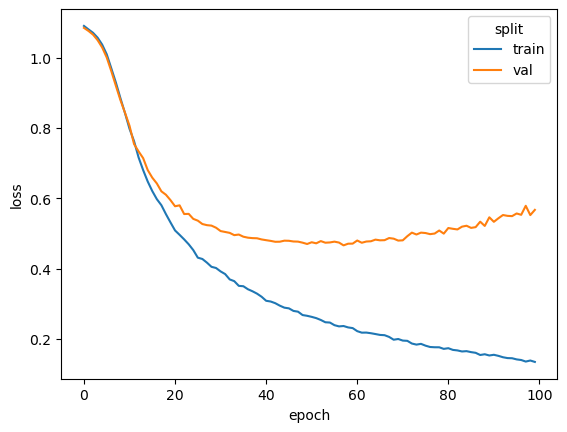

In [9]:
sns.lineplot(data=df,x="epoch", y='loss', hue='split')

<Axes: xlabel='epoch', ylabel='accuracy'>

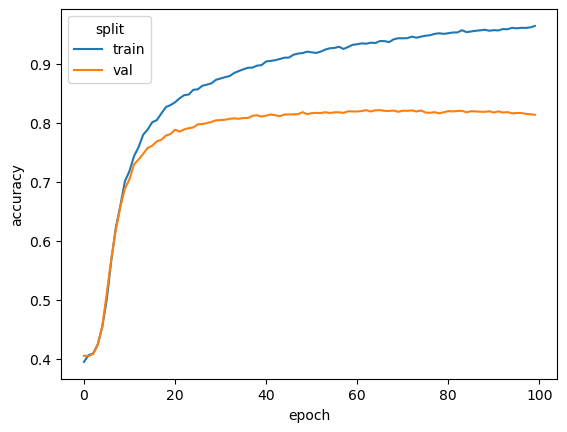

In [10]:
sns.lineplot(data=df,x="epoch", y='accuracy', hue='split')

In [13]:
df.time[df.split == 'train'].mean()

2.1543342065811157

In [15]:
df.time[df.split == 'train'].sum()

215.43342065811157

In [16]:
df.time[df.split == 'val'].sum()

90.29866194725037

In [14]:
df.time[df.split == 'val'].mean()

0.9029866194725037